# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [4]:
from dataloaders import dataset_SparseData
from dataloaders import load_dataset
from loss import losses_SparseData
from models import models_SparseData
from optimizer import load_optimizer

from subprocess import Popen

In [5]:
importlib.reload(dataset_SparseData)

<module 'dataloaders.dataset_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_SparseData.py'>

# Load Shapefile

In [6]:
piedmont_shp = gpd.read_file("/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp",
                                             engine='fiona')
piedmont_shp = piedmont_shp.to_crs('epsg:4326')

# Load dictionary

In [7]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/SparseData/SparseData_Transformer_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'Dataset_Sparse', 'piezo_head': True, 'relative_target': False, 'normalization': True, 'target_norm_type': 'overall_zscore', 'date

# Dataset class

In [8]:
from datetime import date
from dateutil.relativedelta import relativedelta

In [9]:
ds = dataset_SparseData.Dataset_Sparse(dict_files)

    Loading weather data... 

/leonardo_scratch/fast/IscrC_DL4EO/my_venv_fast/lib/python3.11/site-packages/xarray/groupers.py:392: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


Done!
    Loading dtm... Done!
    Loading underground water data... 

/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_SparseData.py:340: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.wtd_df = self.wtd_df.groupby([pd.Grouper(freq=self.config["frequency"], label = "left"), "sensor_id"]).mean()


Done!
    Norm factors:
{'target_means': np.float64(297.7374795222035), 'target_stds': np.float64(73.50297266942587), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.32
    tmin         float32 4B 5.003
    tmean        float32 4B 8.66, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.118
    tmax         float32 4

In [51]:
ds.wtd_df

wtd       lon       lat    height  nan_mask  \
date       sensor_id                                                        
2000-12-31 00103510001        NaN -0.154105  0.053733 -0.866947     False   
           00104110001        NaN  0.094087  0.202696 -0.951262     False   
           00105110001        NaN  0.518426  0.446357 -1.021212     False   
           00105910001   5.918571  0.808310  0.149836 -1.018794      True   
           00105910002        NaN  0.722698  0.233721 -1.028230     False   
...                           ...       ...       ...       ...       ...   
2023-11-30 00417910001   5.102581  0.725215 -0.123456 -0.997253      True   
           00421510001   3.879247  0.642913 -0.516018 -0.929923      True   
           00421710001   6.450495  0.446580 -0.380864 -0.962027      True   
           00422510001  25.986726  0.364473 -0.911923 -0.777247      True   
           00425010001   4.909785  0.463569 -0.751001 -0.852743      True   

                               h  
date       sensor_id              
2000-12-31 00103510001       NaN  
           00104110001       NaN  
           00105110001       NaN  
           00105910001 -0.892394  
           00105910002       NaN  
...                          ...  
2023-11-30 00417910001 -0.621990  
           00421510001  0.205153  
           00421710001 -0.216290  
           00422510001  1.742230  
           00425010001  1.120193  

[7728 rows x 6 columns]

In [47]:
len(ds.dates) * 31

8556

In [69]:
gdf_coords['x']

0     7.308503
1     7.415599
2     7.598704
3     7.723791
4     7.686849
5     7.381028
6     7.574672
7     7.673142
8     7.534463
9     7.847733
10    7.494797
11    7.655552
12    7.718708
13    7.564895
14    7.339481
15    7.845734
16    7.489818
17    7.735140
18    7.640289
19    7.537215
20    7.726400
21    7.649651
22    7.529275
23    7.687935
24    7.652421
25    7.567702
26    7.532273
27    7.575033
Name: x, dtype: float64

In [196]:
ds[100][2][0].shape

torch.Size([23, 3, 9, 12])

In [172]:
ds.twindow

3

In [197]:
ds[100][0].shape

torch.Size([3, 28, 4])

In [96]:
mask = ds.wtd_df[["wtd","h"]].isna().all(axis=1)
all_nan_level0 = mask.groupby(level=0).all()
result = all_nan_level0[all_nan_level0].index
result

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

In [97]:
ds.weather_xr

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 854, lat: 9, lon: 12)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
  * time         (time) datetime64[ns] 7kB 1958-08-03 1958-08-31 ... 2023-12-24
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, lat, lon) float32 369kB -1.075 -1.078 ... -1.168 -1.113
    tmax         (time, lat, lon) float32 369kB 0.8992 0.9831 ... 0.01476
    tmin         (time, lat, lon) float32 369kB 0.1359 0.1613 ... -0.6864
    tmean        (time, lat, lon) float32 369kB 0.5176 0.5722 ... -0.3358
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 14 07:41:14 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

(44.2, 45.5)

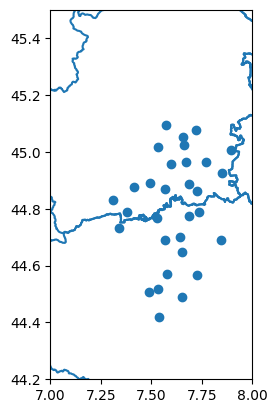

In [104]:
fig, ax = plt.subplots()
piedmont_shp.boundary.plot(ax = ax)
ds.wtd_names.plot(ax = ax)
ax.set_xlim(7,8)
ax.set_ylim(44.2,45.5)

In [163]:
idx = 0
start_date_input = np.datetime64(ds.dates[idx]).astype(f"datetime64[{ds.config['frequency']}]"); print(start_date_input)
end_date_input = start_date_input.astype(f"datetime64[{ds.config['frequency']}]")  + np.timedelta64(ds.twindow-1, ds.config["frequency"]); print(end_date_input)

2000-12
2001-02


In [164]:
(end_date_input-start_date_input).astype(f'timedelta64[{ds.config["frequency"]}]').astype(int) + 1

np.int64(3)

In [173]:
ds.wtd_df["h"].loc[pd.IndexSlice[start_date_input:end_date_input, :]] 

date        sensor_id  
2000-12-31  00103510001           NaN
            00104110001           NaN
            00105110001           NaN
            00105910001    232.143837
            00105910002           NaN
            00107010001           NaN
            00109010001           NaN
            00112710001    219.234953
            00117110001           NaN
            00119710001           NaN
            00126010001    257.842520
            00127210001    226.808526
            00127210003           NaN
            00131010001           NaN
            00401210001           NaN
            00402910001           NaN
            00403410001           NaN
            00404110001           NaN
            00405910001    283.132983
            00407810001    477.504439
            00408910001    351.463979
            00408910002           NaN
            00414310002           NaN
            00417910001    252.959042
            00421510001           NaN
            00421710001   

In [198]:
sample_date = np.datetime64("2002-12-31")
ds.get_target_data(sample_date, sample_date)

ValueError: cannot reshape array of size 28 into shape (0,28)

In [105]:
ds.wtd_names

,sensor_id,wb_id,loc_name,munic,loc,sart_date,end_date,gw_type,geometry,height
0,00103510001,GWB-S5b,P45 Bricherasio,Bricherasio,Piazzale cimitero,2009-01-01,None,Shallow,POINT (7.3085 44.82984),372.416901
1,00104110001,GWB-S5a,P24 Buriasco,Buriasco,davanti cimitero,2009-01-01,None,Shallow,POINT (7.4156 44.87792),297.815430
2,00104810001,GWB-S4a,P40 Area verde via Triberti,Cambiano,Via CavagliÃ,2019-01-01,None,Shallow,POINT (7.77064 44.96545),242.111877
3,00105110001,GWB-S3b,P20 Candiolo,Candiolo,davanti cimitero,2009-01-01,None,Shallow,POINT (7.5987 44.95656),235.923615
4,00105910001,GWB-S4b,P16 Carmagnola,Carmagnola,"Peso pubblico, P.za della Concordia",2009-01-01,None,Shallow,POINT (7.72379 44.86086),238.062408
5,00105910002,GWB-S5a,TF2 Tetto Frati Carmagnola,Carmagnola,C/o Centro Sperimentale della FacoltÃ di Agraria,2009-01-01,None,Shallow,POINT (7.68685 44.88793),229.713989
6,00107010001,GWB-S5b,P15 Cavour,Cavour,lato cimitero,2009-01-01,None,Shallow,POINT (7.38103 44.78737),297.513123
7,00109010001,GWB-S3b,P18 Collegno,Collegno,su strada in via della Piombia,2009-01-01,None,Shallow,POINT (7.57467 45.0939),291.650299
8,00112710001,GWB-S5a,P19 La Loggia,La Loggia,"Zona industriale, parcheggio Via D. Vittorio",2009-01-01,None,Shallow,POINT (7.67314 44.963),223.828842
9,00117110001,GWB-S3b,P10 Orbassano,Orbassano,piazzale campo sportivo,2009-01-01,None,Shallow,POINT (7.53446 45.0163),272.287170


In [106]:
ds.wtd_df.index.get_level_values(1)[:16]

Index(['00103510001', '00104110001', '00104810001', '00105110001',
       '00105910001', '00105910002', '00107010001', '00109010001',
       '00112710001', '00117110001', '00119710001', '00121510001',
       '00126010001', '00127210001', '00127210003', '00127210005'],
      dtype='object', name='sensor_id')

In [10]:
timestep = 24
print(ds[100][0][timestep+1,:,-1], end = "\n\n")
print(ds[100][3][timestep,:])
print(ds[100][-1][timestep,:])

tensor([-0.4382,  0.0000,  0.0000,  0.5117,  0.1556,  0.0000,  0.0000, -0.9755,
         0.0000,  0.0000,  0.0444, -0.0921,  0.0000,  0.0000,  0.3592, -1.0354,
         0.7864,  0.0000, -0.2810, -0.1611,  0.6963,  0.0000, -0.0750, -0.1094,
         0.8905,  0.0000,  0.8989,  0.6274])

tensor([-0.4382,  0.0000,  0.0000,  0.5117,  0.1556,  0.0000,  0.0000, -0.9755,
         0.0000,  0.0000,  0.0444, -0.0921,  0.0000,  0.0000,  0.3592, -1.0354,
         0.7864,  0.0000, -0.2810, -0.1611,  0.6963,  0.0000, -0.0750, -0.1094,
         0.8905,  0.0000,  0.8989,  0.6274])
tensor([ True, False, False,  True,  True, False, False,  True, False, False,
         True,  True, False, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True])


<Axes: xlabel='wtd', ylabel='Count'>

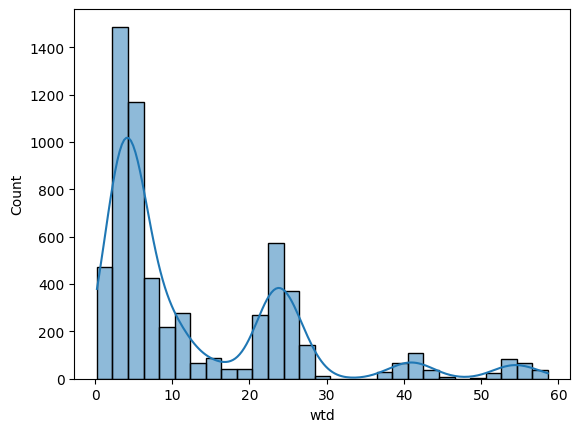

In [11]:
sns.histplot(ds.wtd_df["wtd"], kde=True)

<Axes: ylabel='Count'>

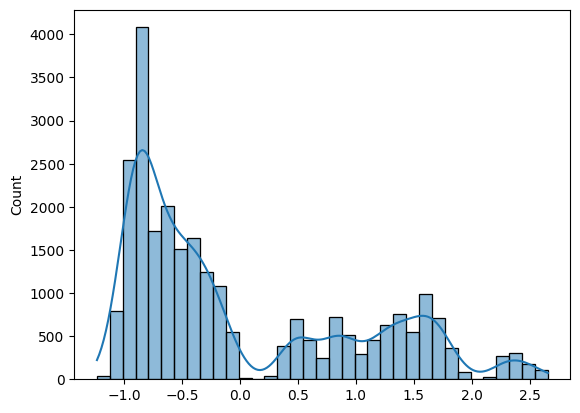

In [23]:
new_var = ds.wtd_df["wtd"]/ds.wtd_df["height"]
new_var_mean = new_var.mean()
new_var_std = new_var.std()
sns.histplot((new_var-new_var_mean)/new_var_std, kde=True)

<Axes: ylabel='Count'>

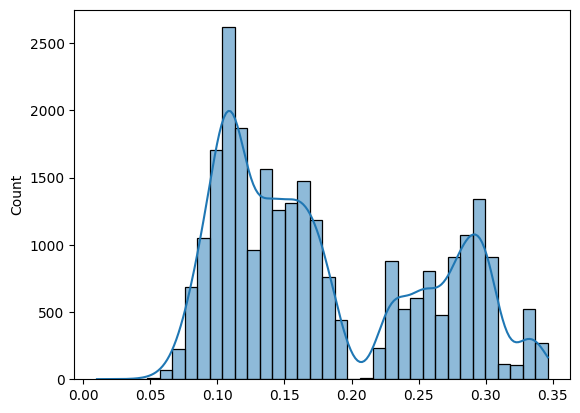

In [26]:
new_var = np.sqrt(ds.wtd_df["wtd"]/ds.wtd_df["height"])
new_var_mean = new_var.mean()
new_var_std = new_var.std()
#new_var = (new_var-new_var_mean)/new_var_std
sns.histplot(new_var, kde=True)

In [31]:
ds.weather_xr.time.dt.year - 2000

<xarray.DataArray 'year' (time: 3410)> Size: 27kB
array([-42, -42, -42, ...,  23,  23,  23])
Coordinates:
  * time         (time) datetime64[ns] 27kB 1958-08-24 1958-08-31 ... 2023-12-24
    spatial_ref  int64 8B 0

<Axes: ylabel='Count'>

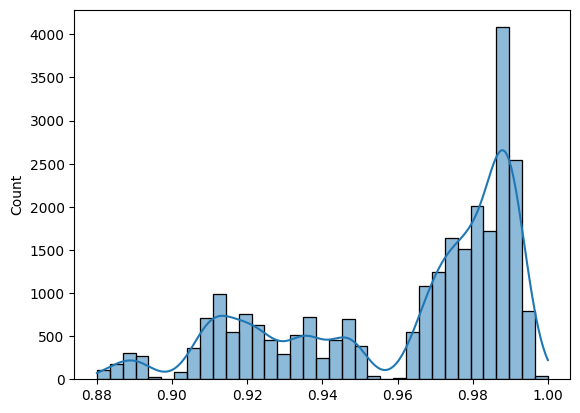

In [28]:
new_var = ds.wtd_df["h"]/ds.wtd_df["height"]
new_var_mean = new_var.mean()
new_var_std = new_var.std()
#new_var = (new_var-new_var_mean)/new_var_std
sns.histplot(new_var, kde=True)

<Axes: xlabel='h', ylabel='Count'>

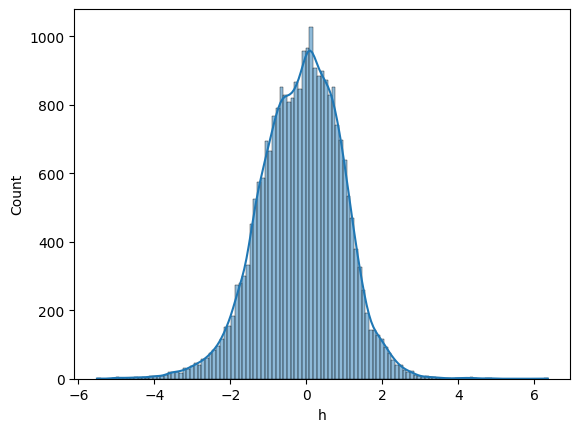

In [12]:
sns.histplot(ds.wtd_df["h"], kde=True)

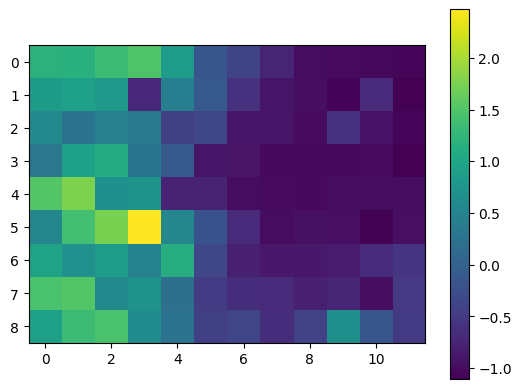

In [200]:
plt.imshow(ds[0][2][0][2,2,:,:])
plt.colorbar()
plt.show()

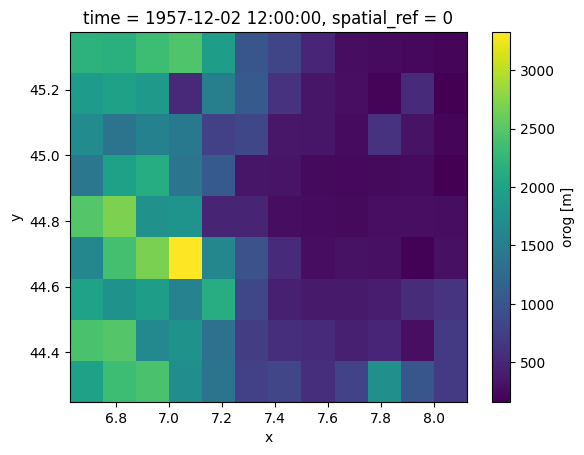

In [201]:
ds.weather_dtm.plot()

In [15]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

In [16]:
import geopy.distance

In [17]:
spatial_resolution_meteo =  geopy.distance.geodesic((ds.weather_xr.lat.values[4],
                               ds.weather_xr.lon.values[0]),
                               (ds.weather_xr.lat.values[5],
                                ds.weather_xr.lon.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_meteo, 5))

Y - Resolution in km:  13.89086


In [18]:
spatial_resolution_dtm =  geopy.distance.geodesic((ds.dtm_roi.y.values[4],
                               ds.dtm_roi.x.values[0]),
                               (ds.dtm_roi.y.values[5],
                                ds.dtm_roi.x.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_dtm, 5))

Y - Resolution in km:  0.09261


# TS Plot

/scratch_local/ipykernel_3316216/2395287352.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (25,4))


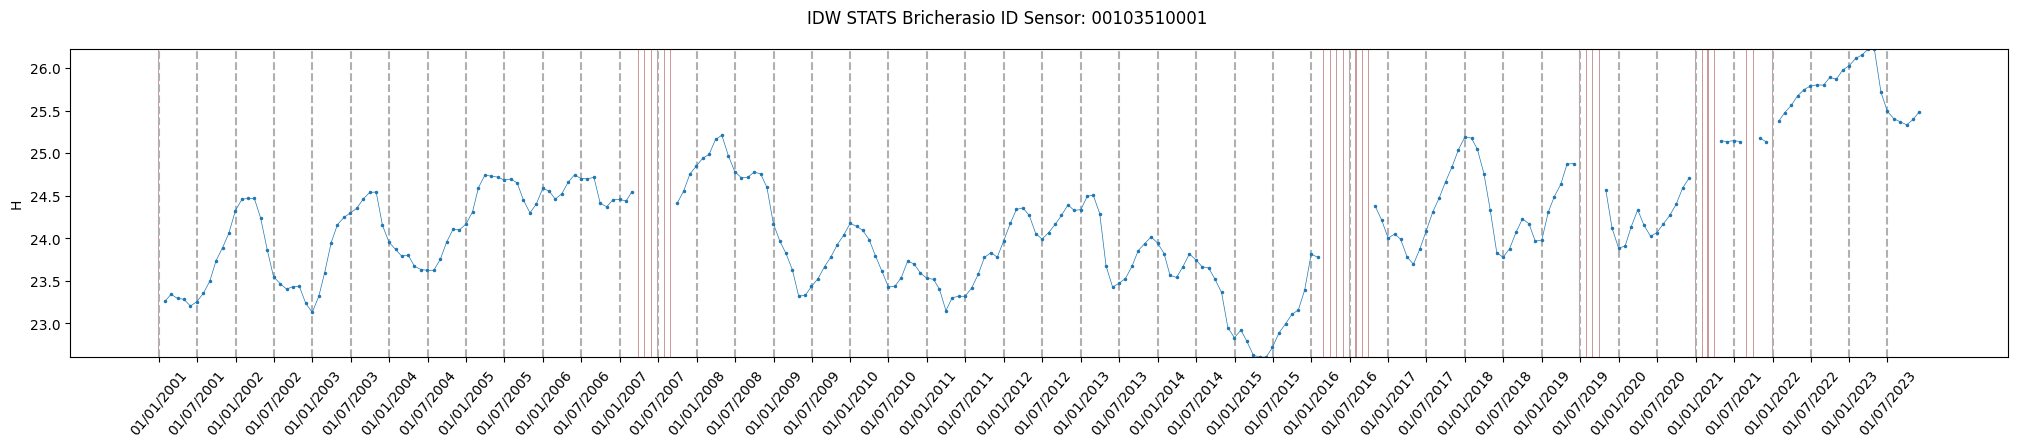

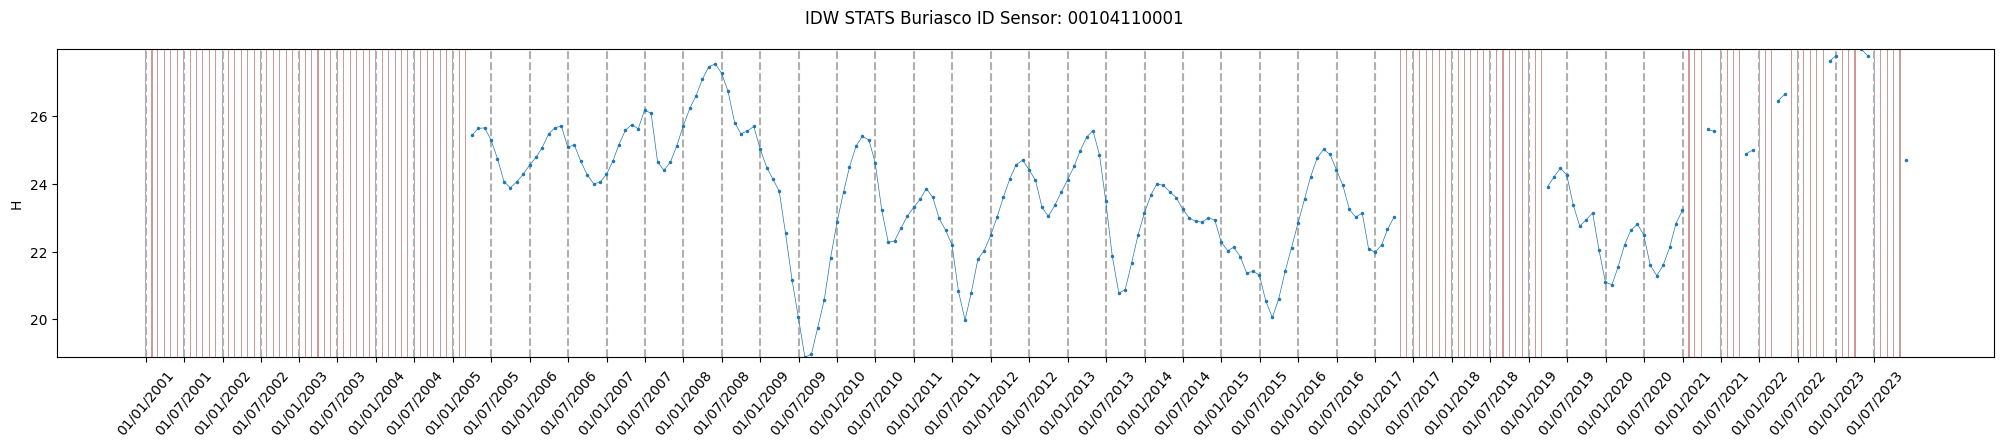

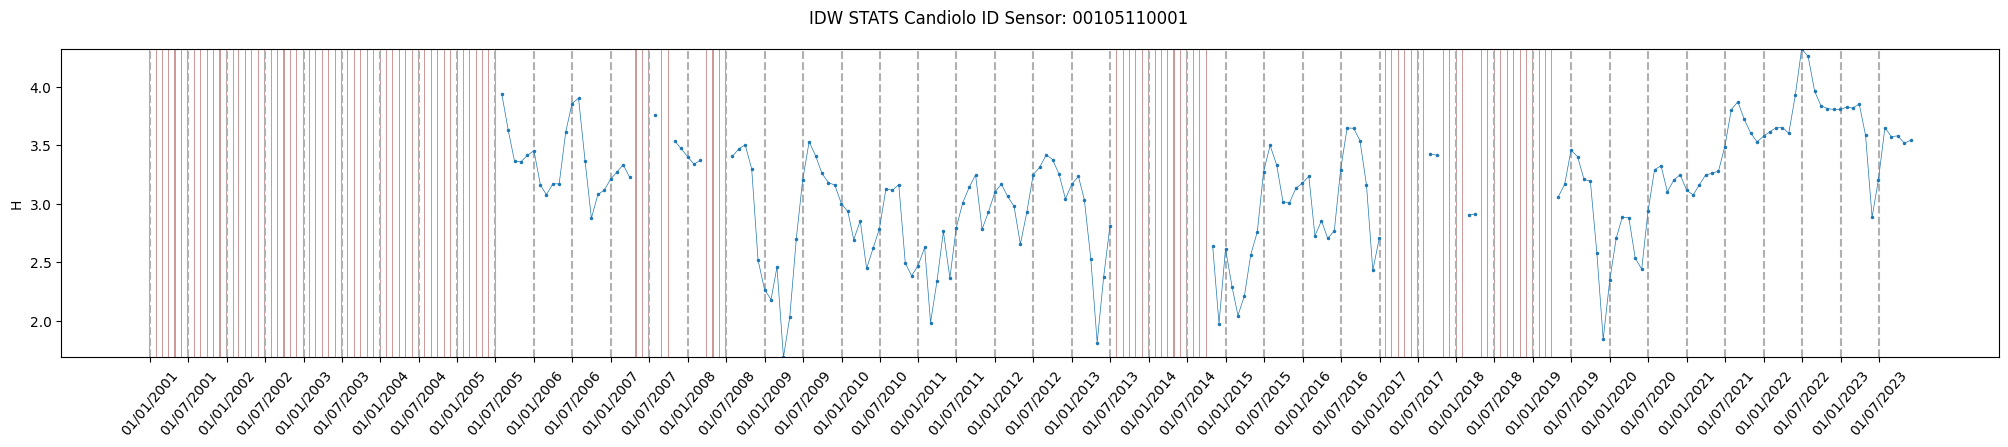

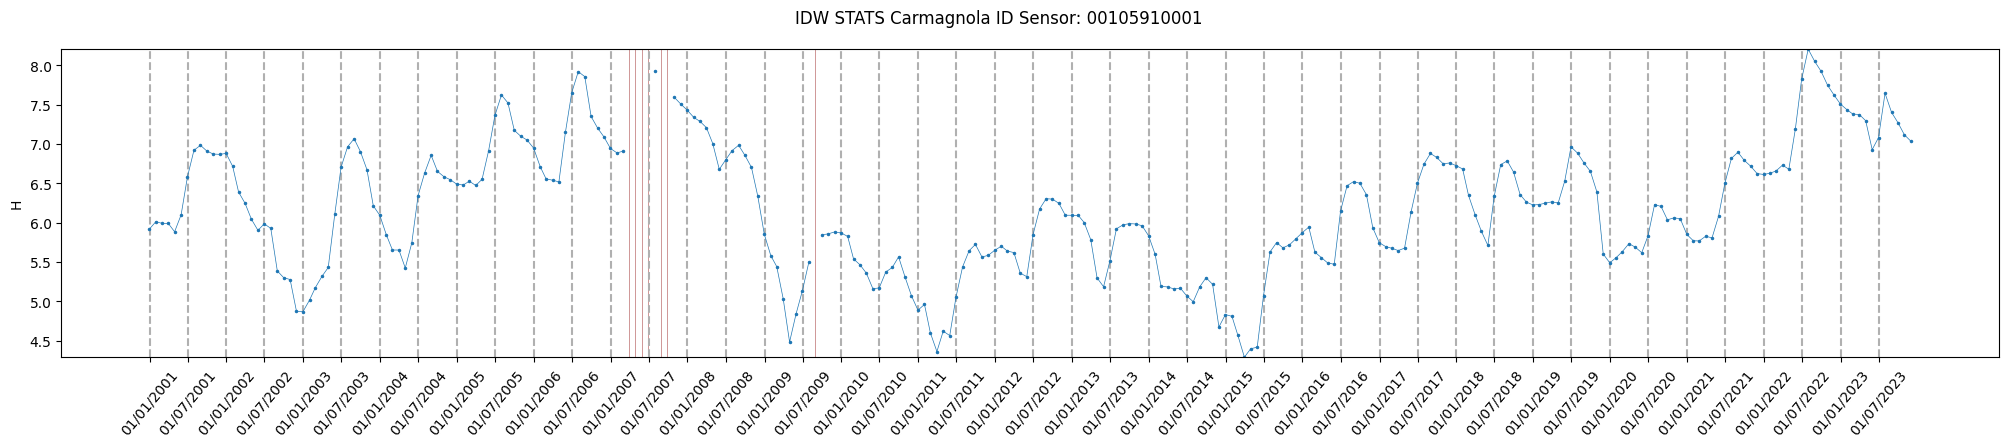

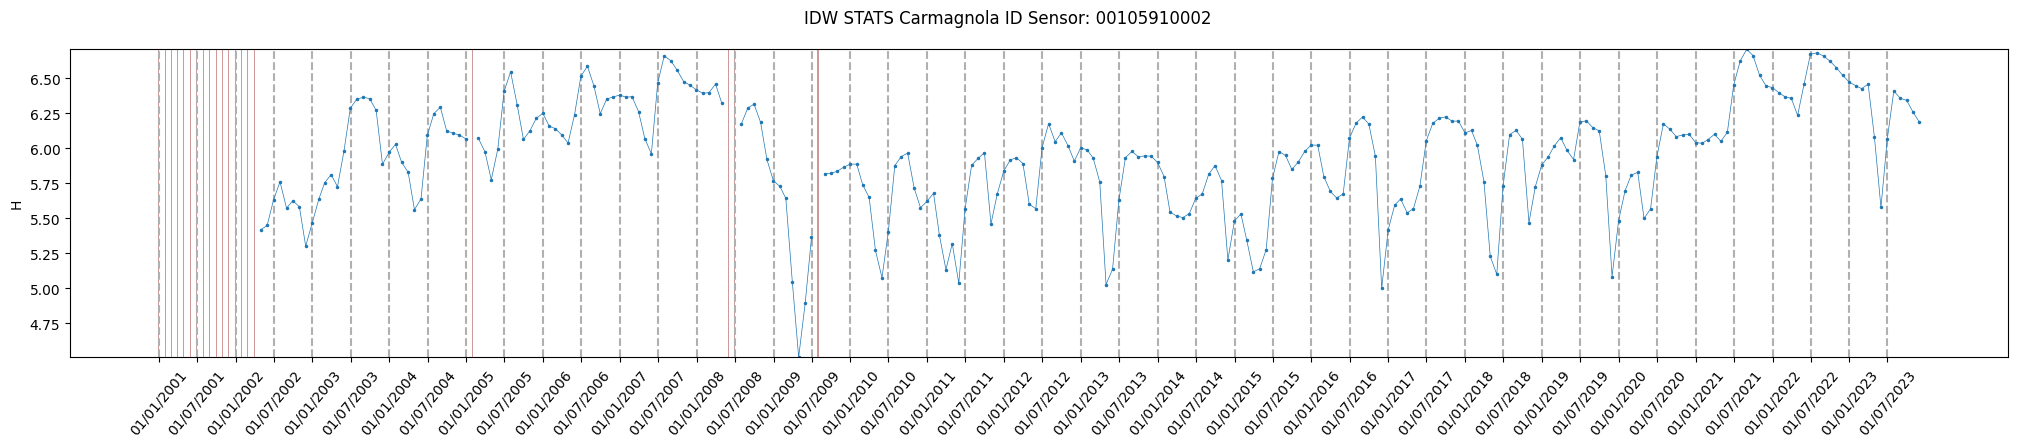

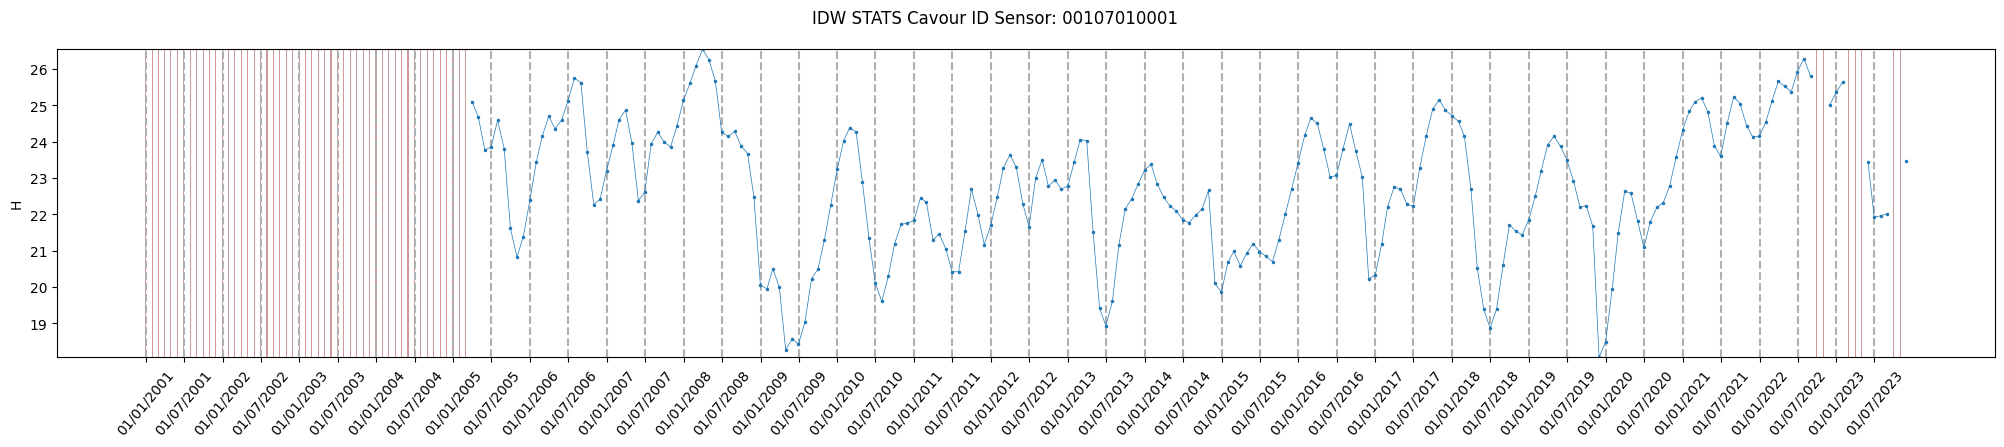

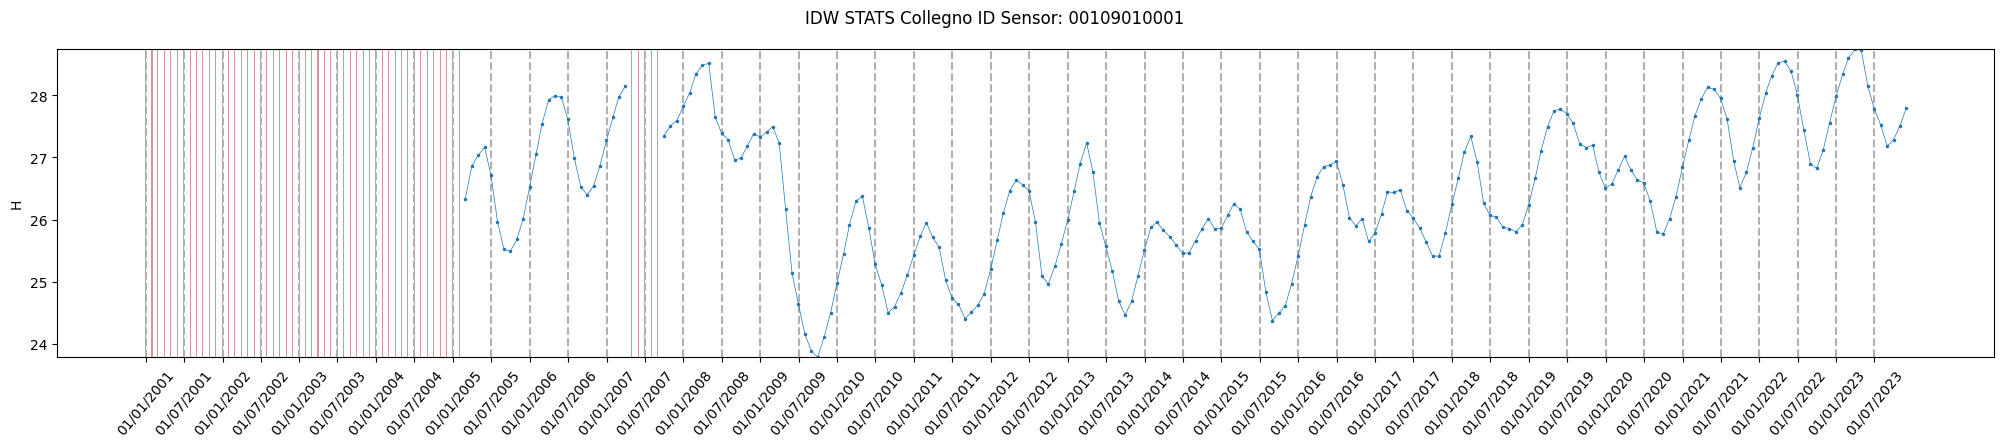

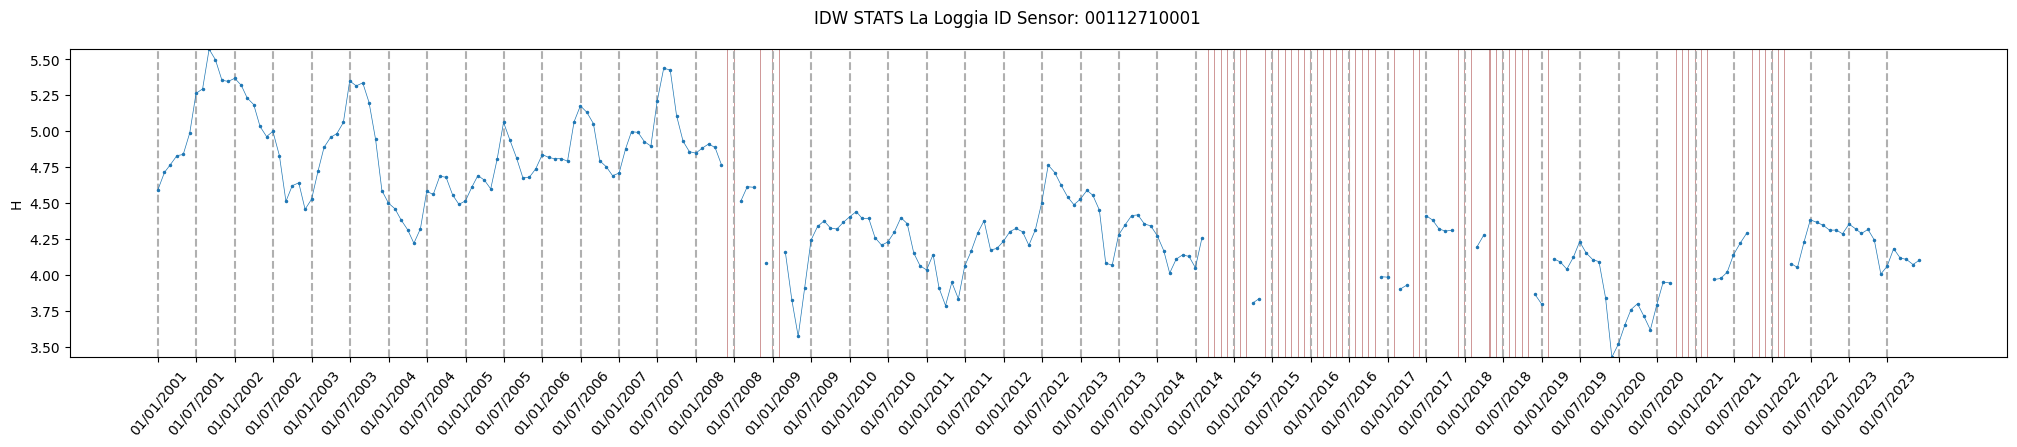

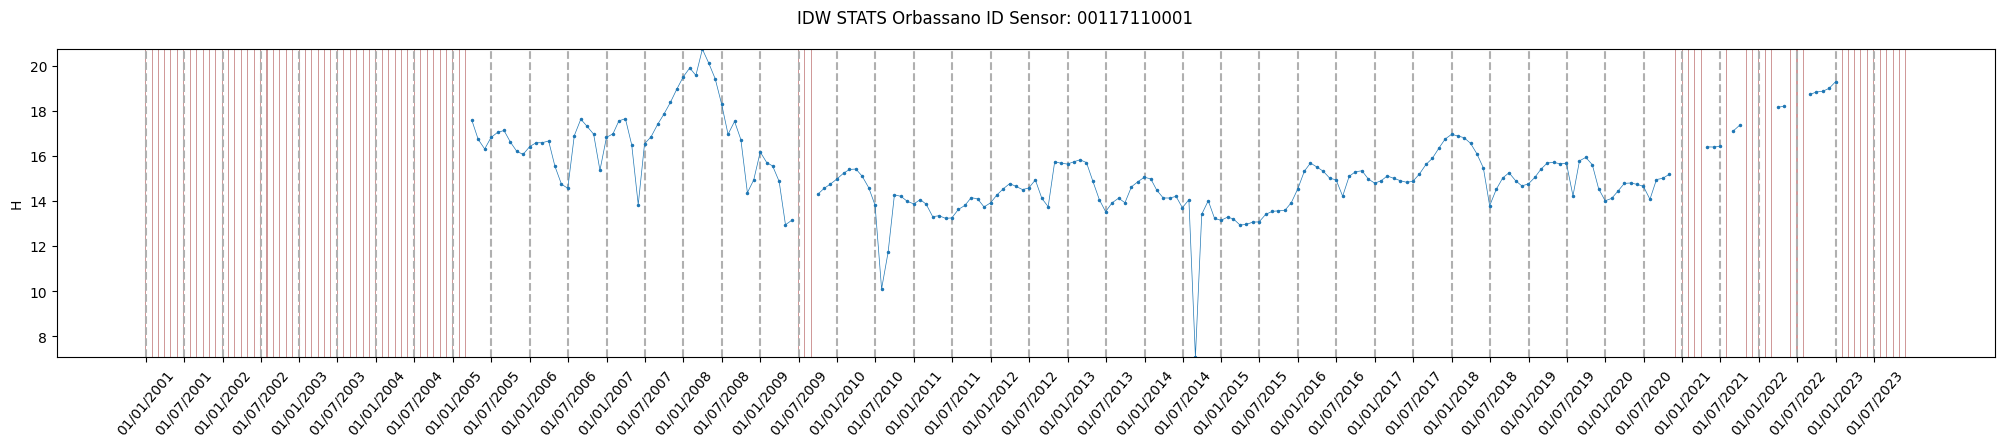

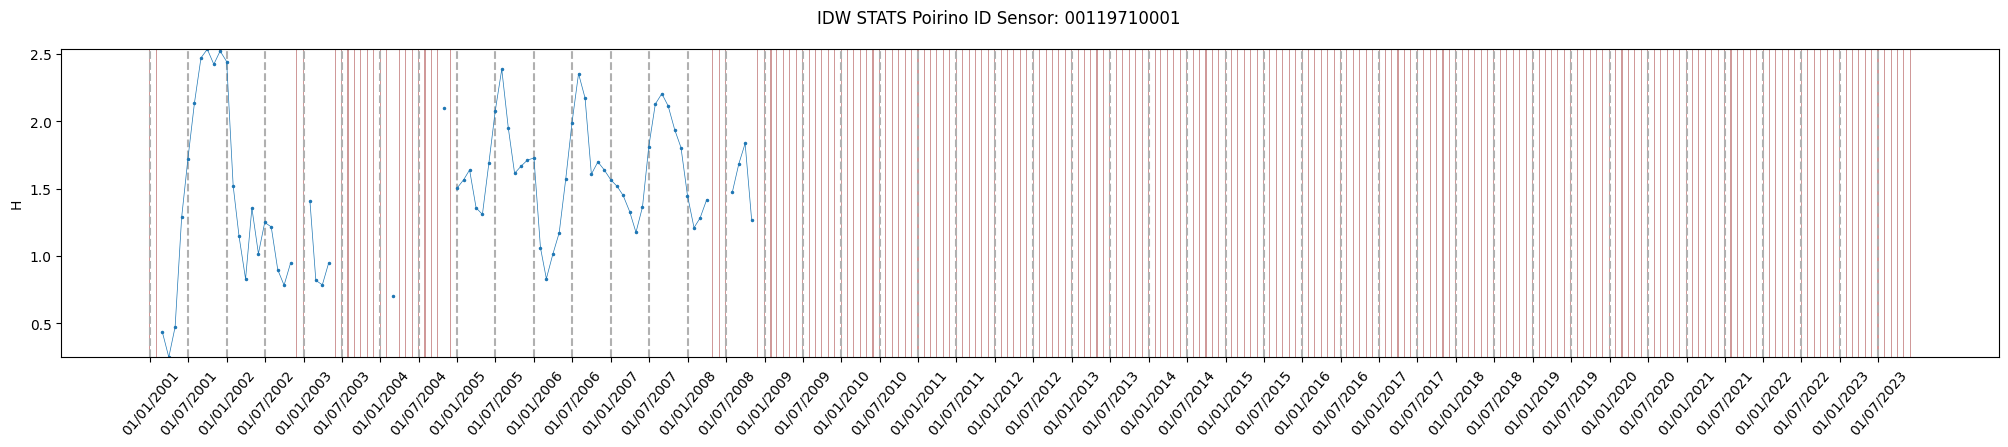

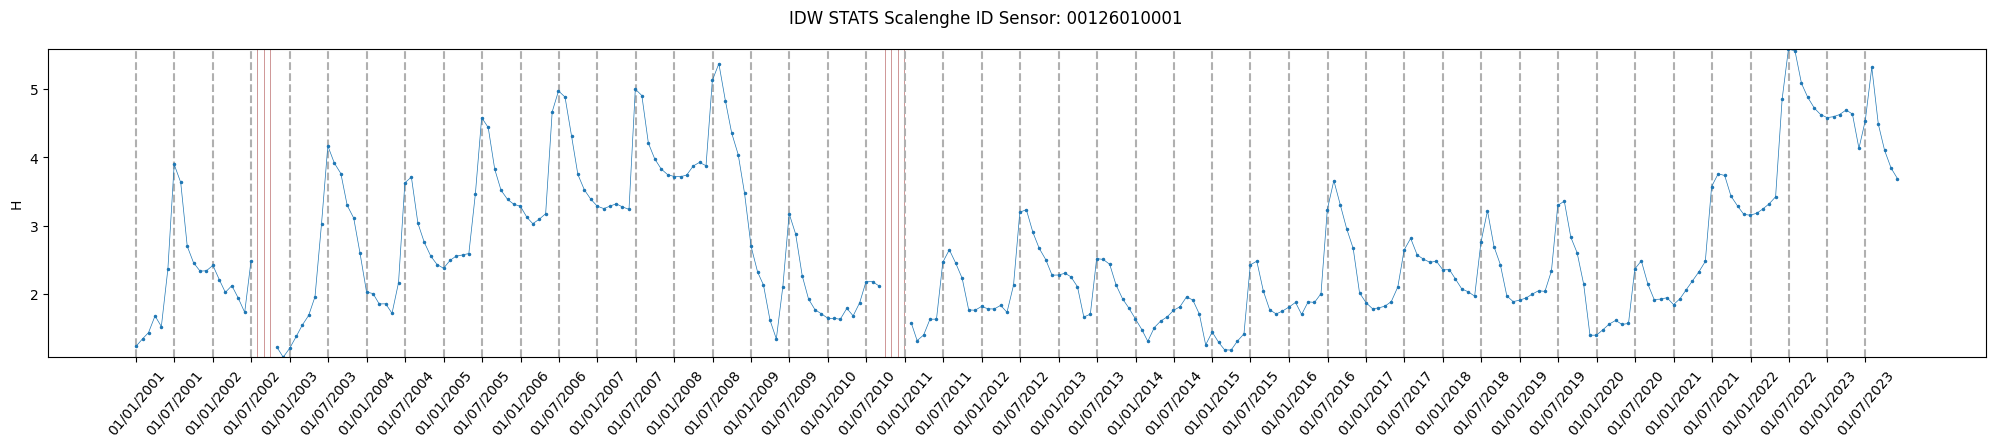

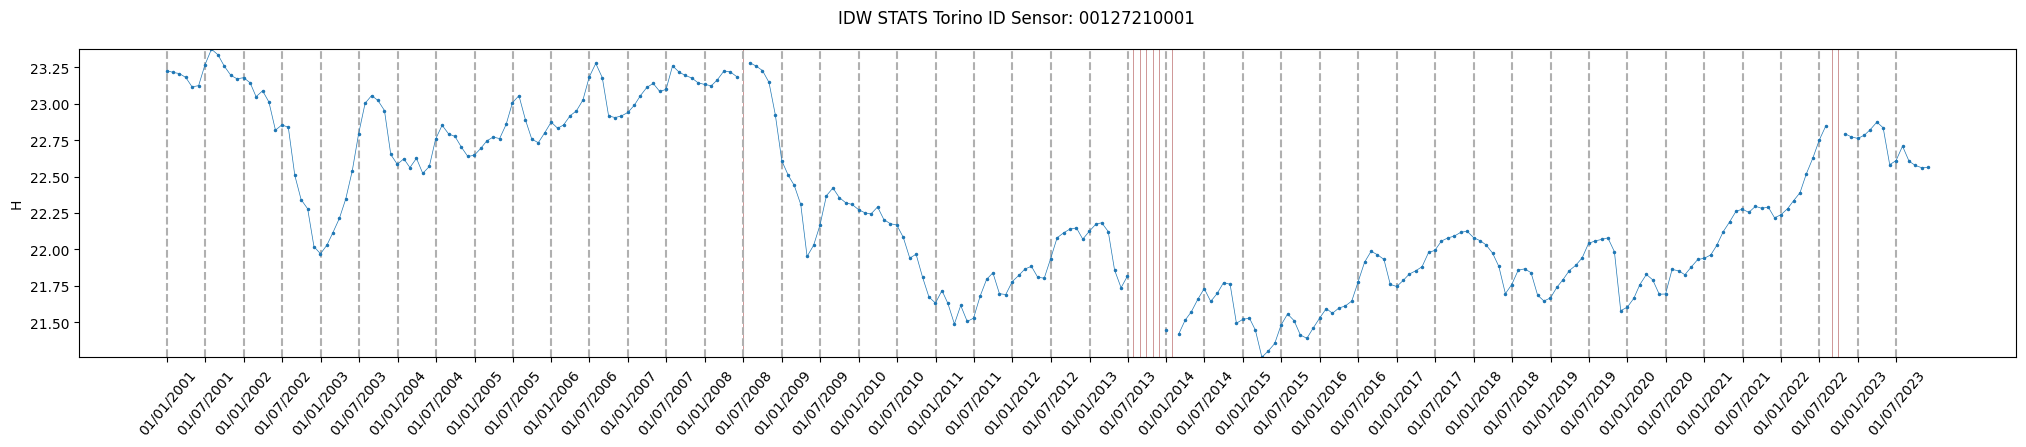

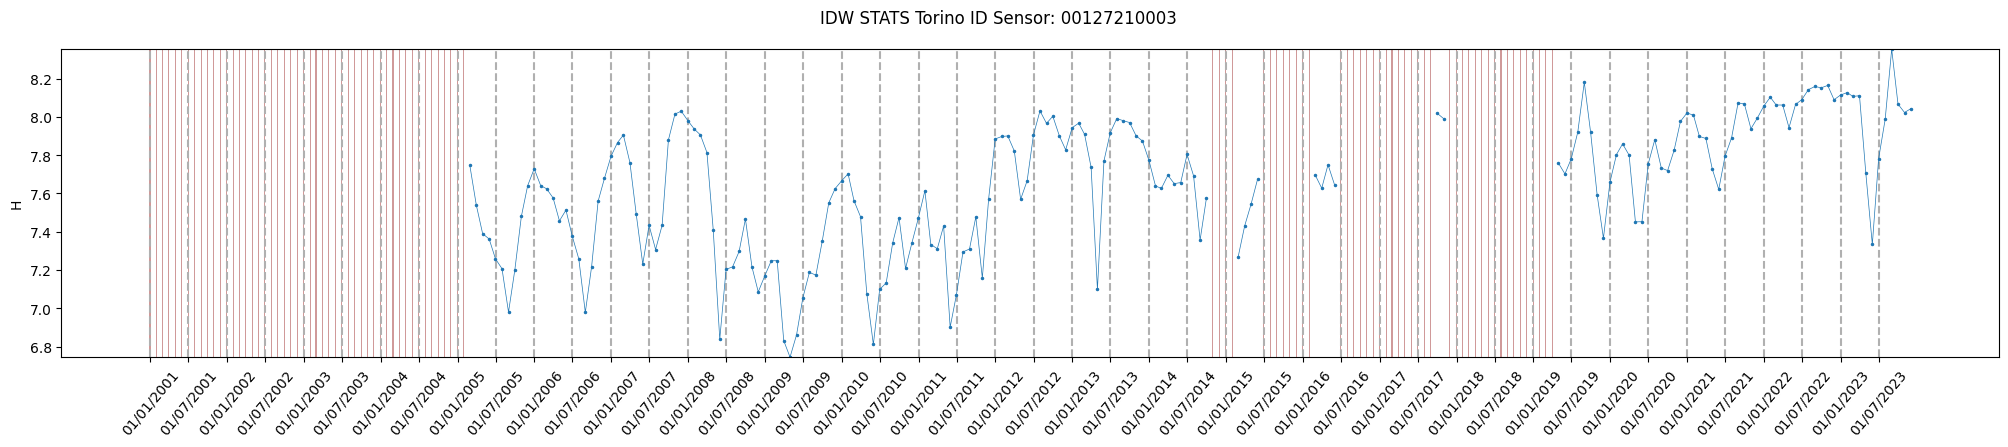

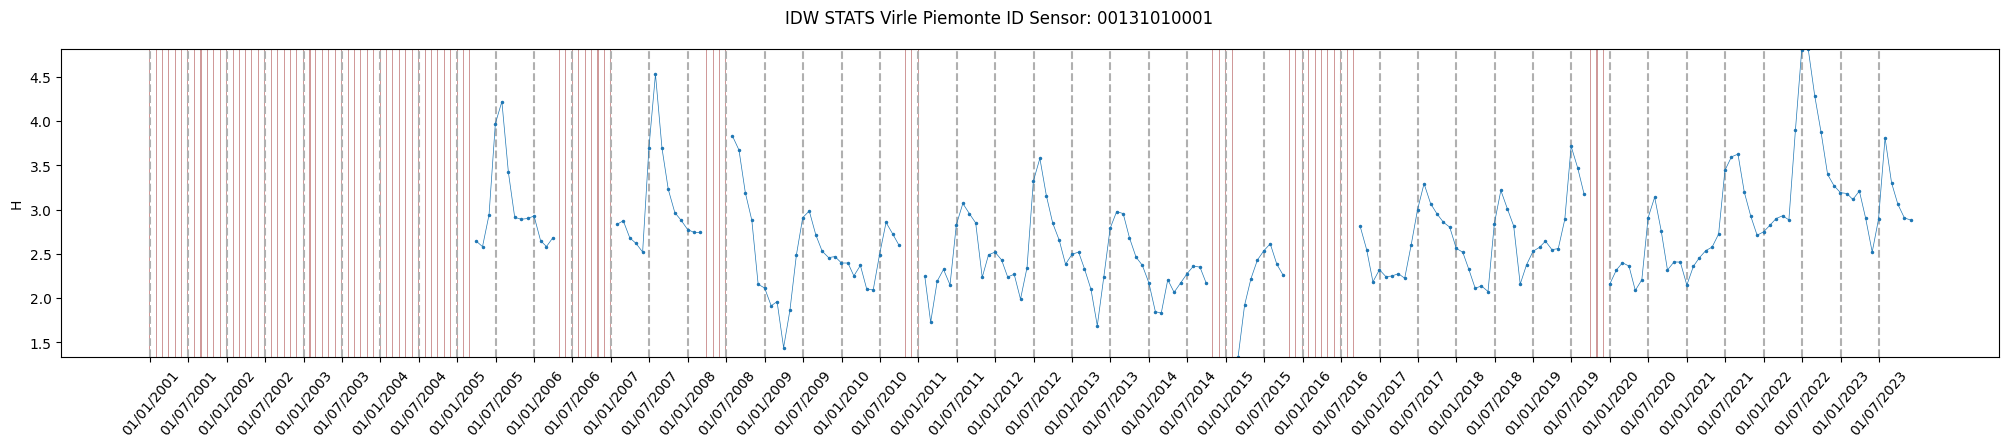

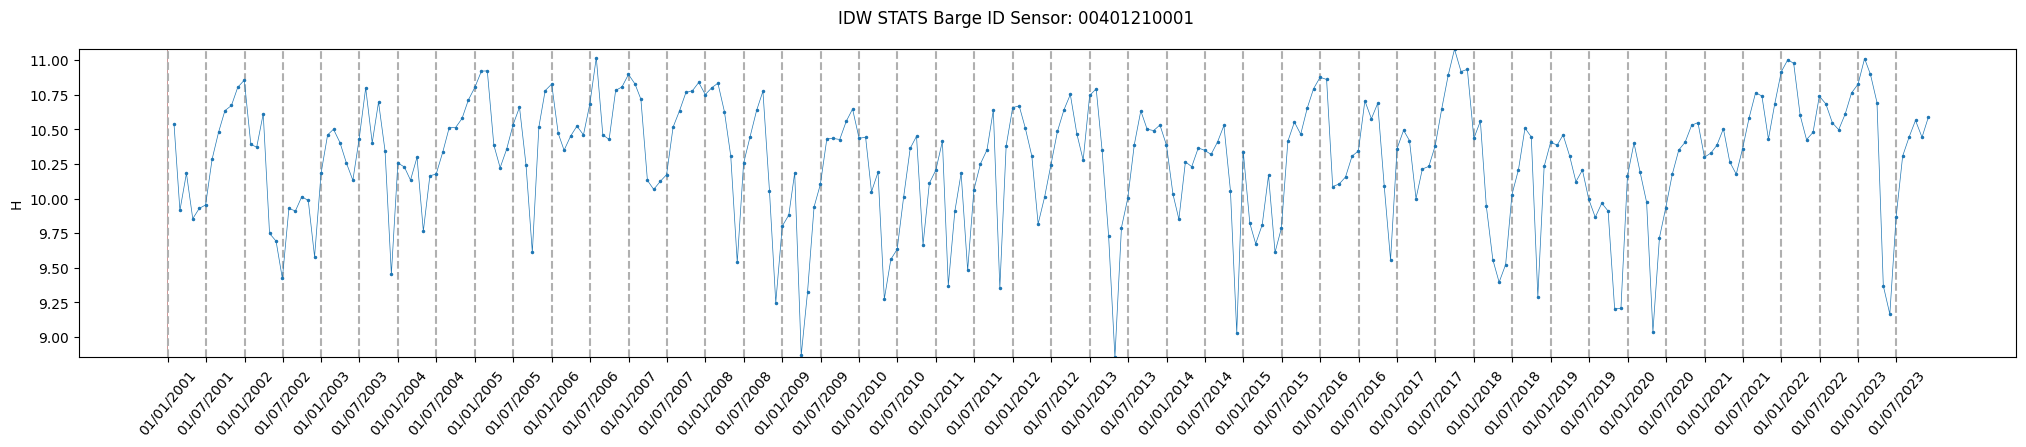

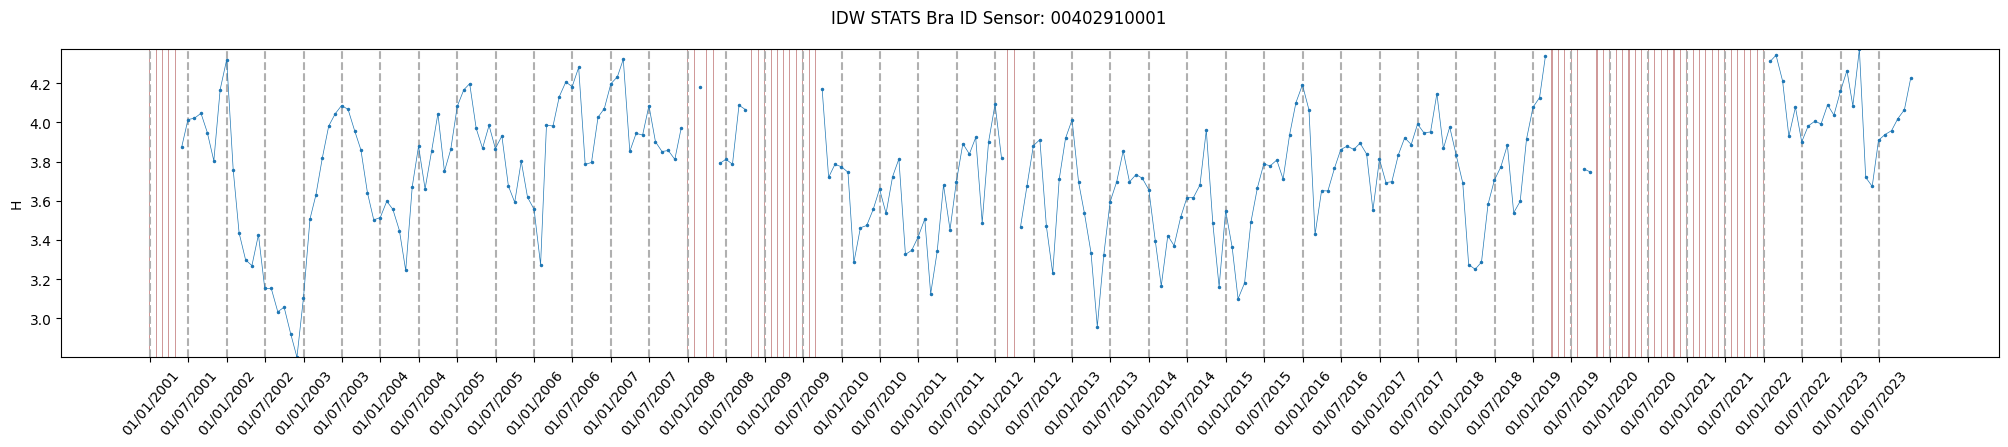

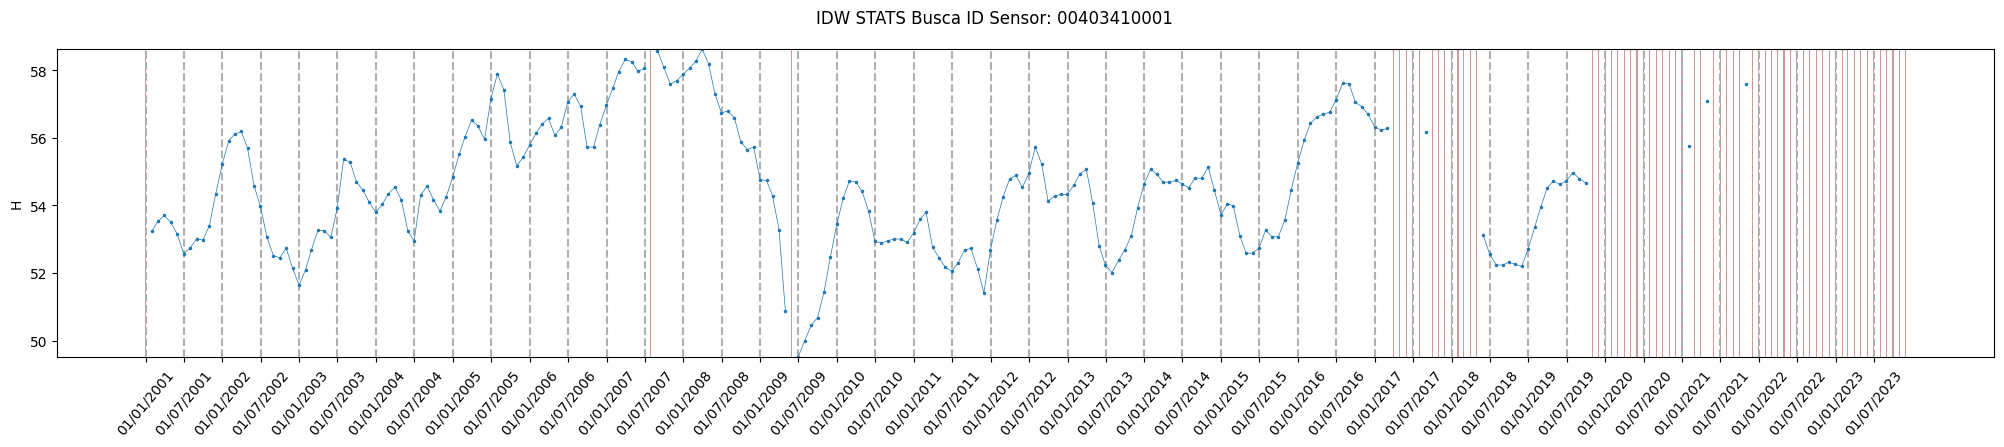

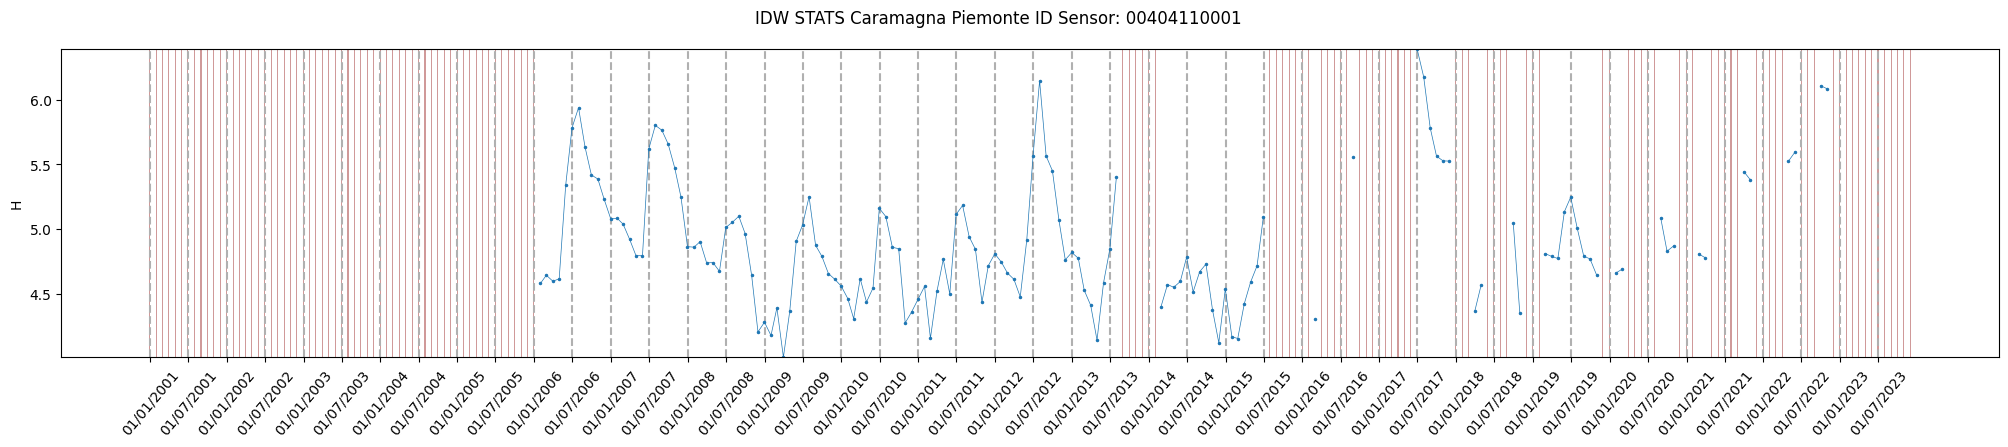

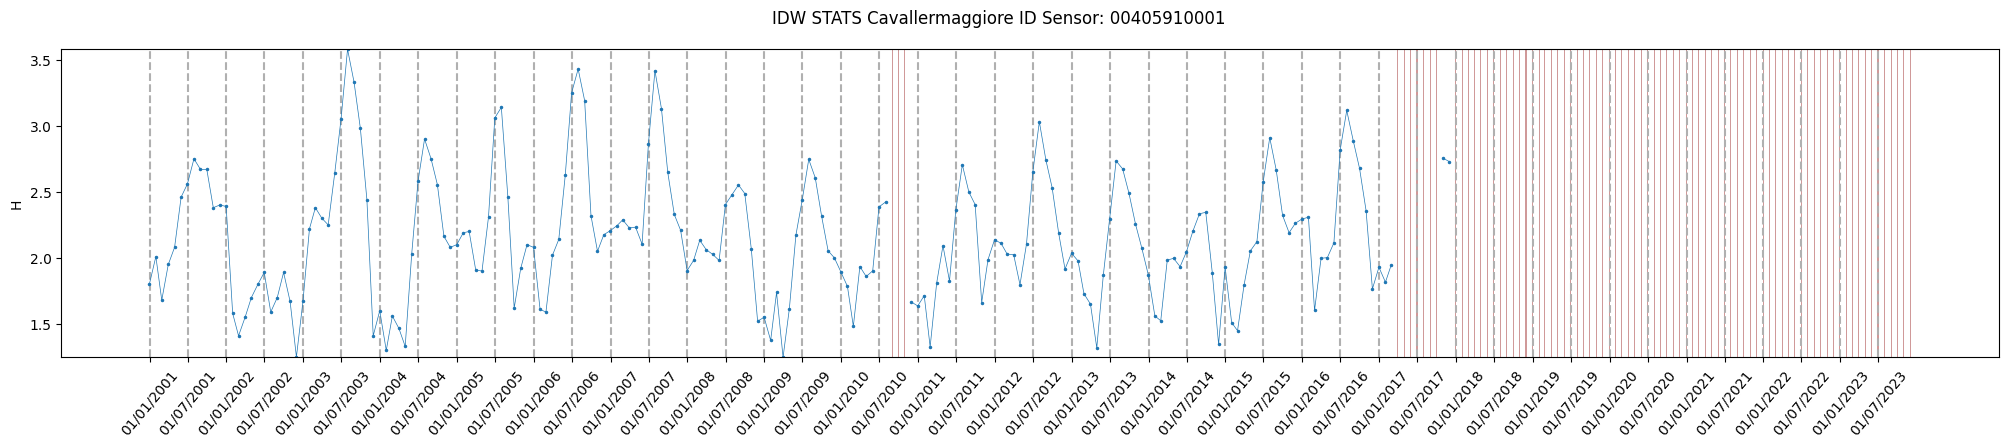

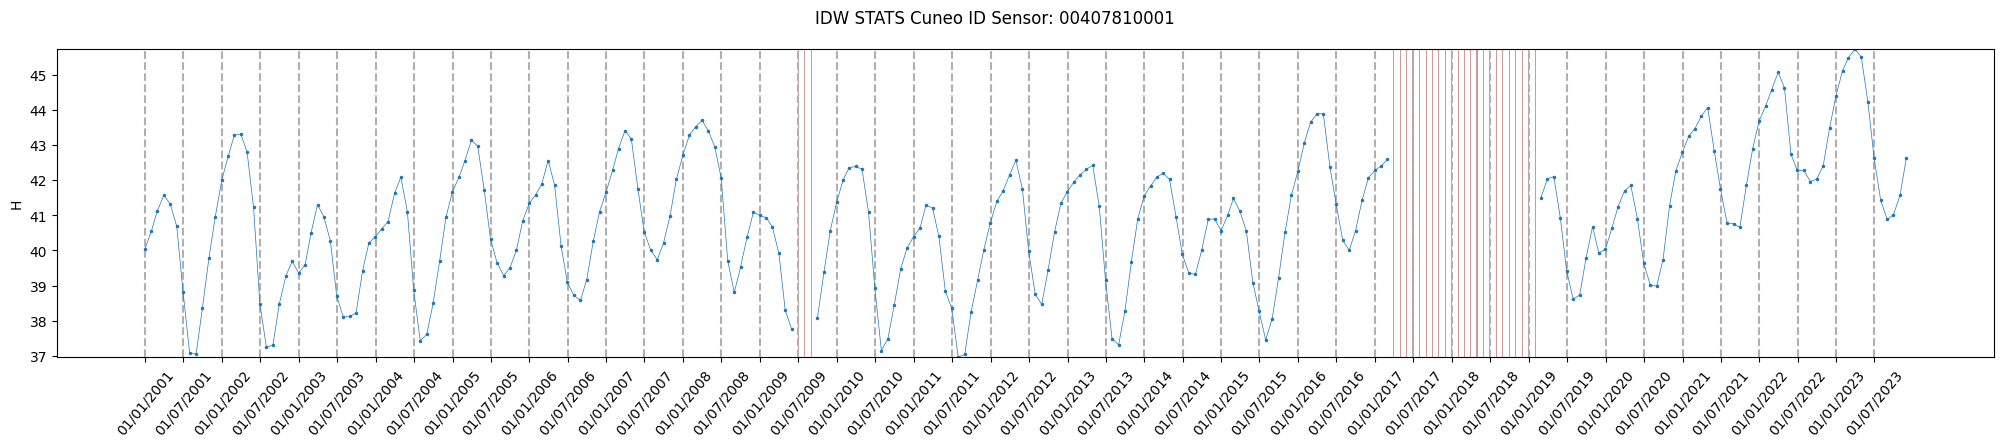

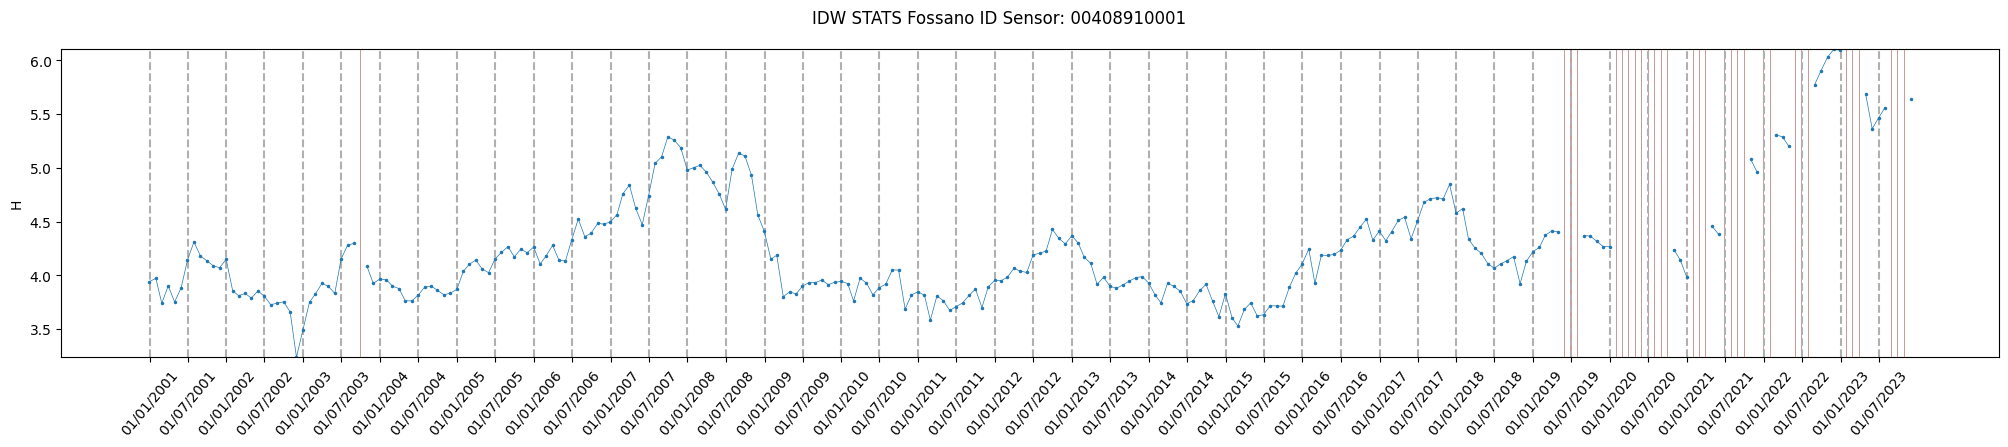

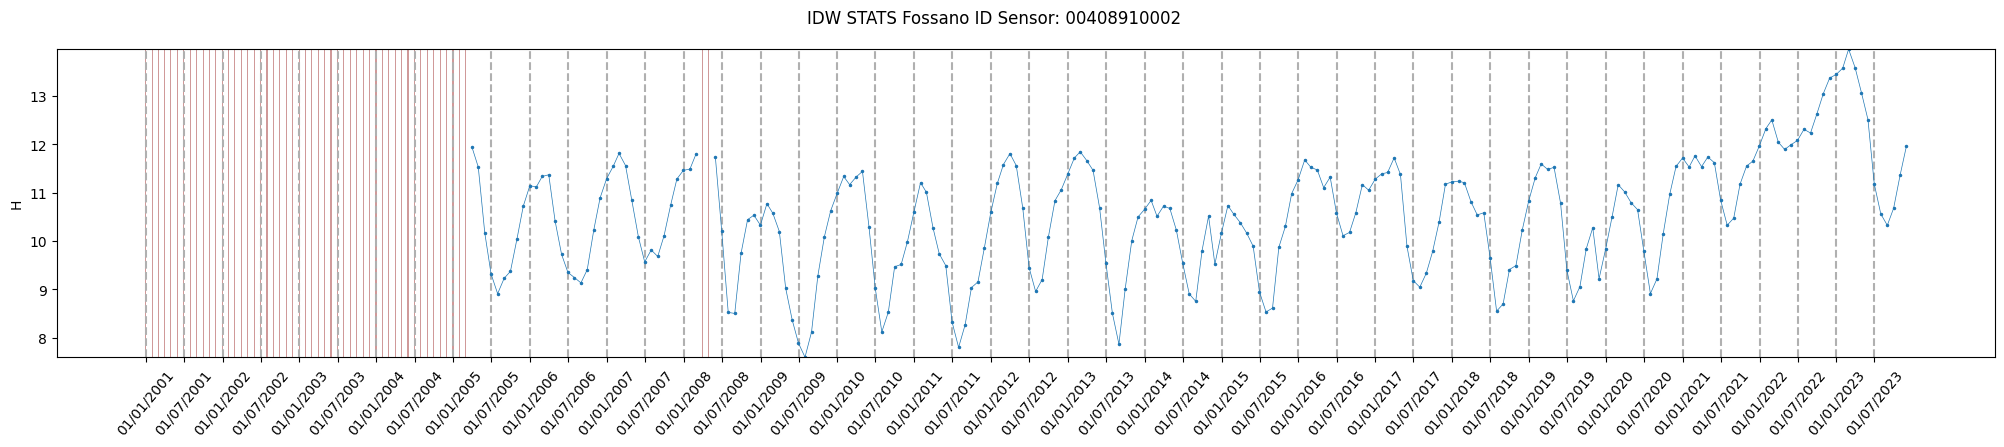

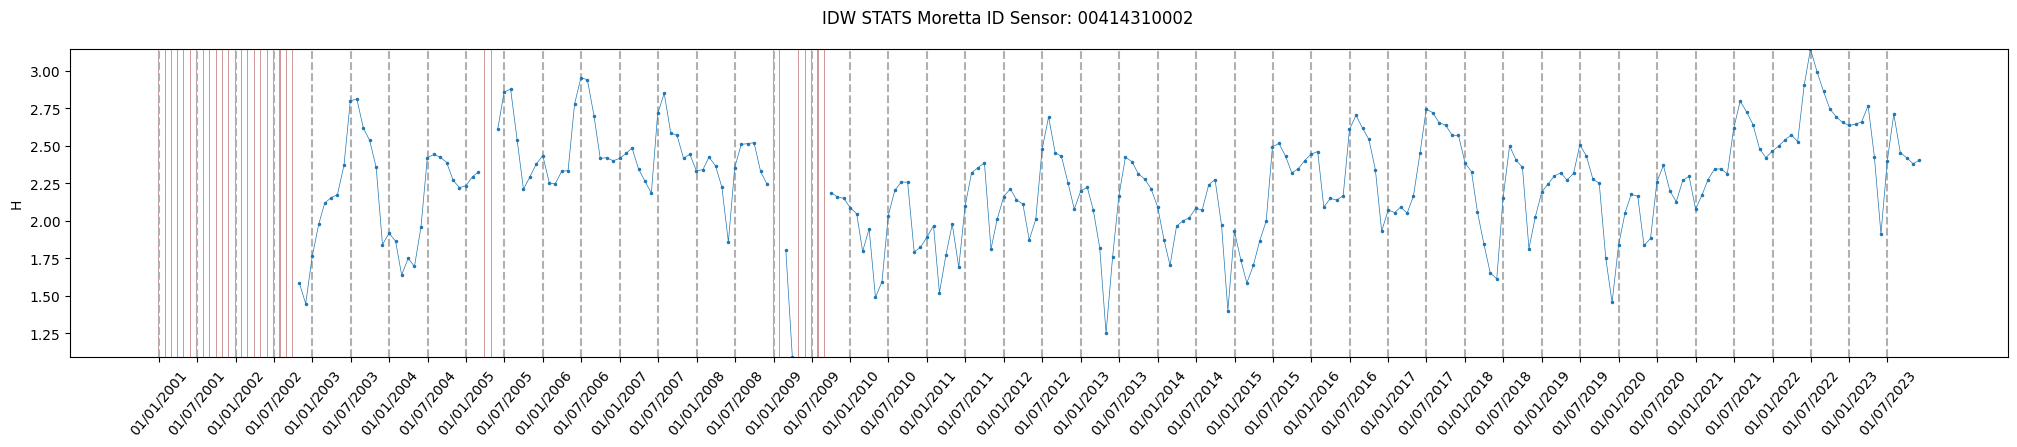

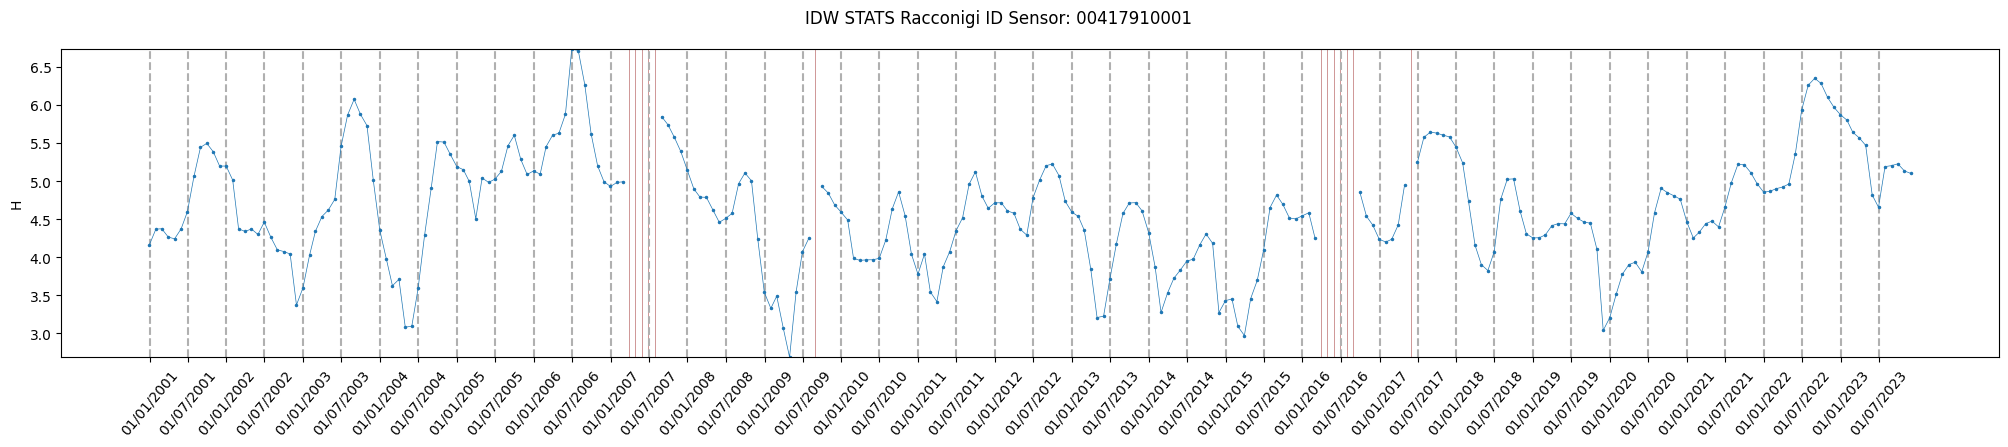

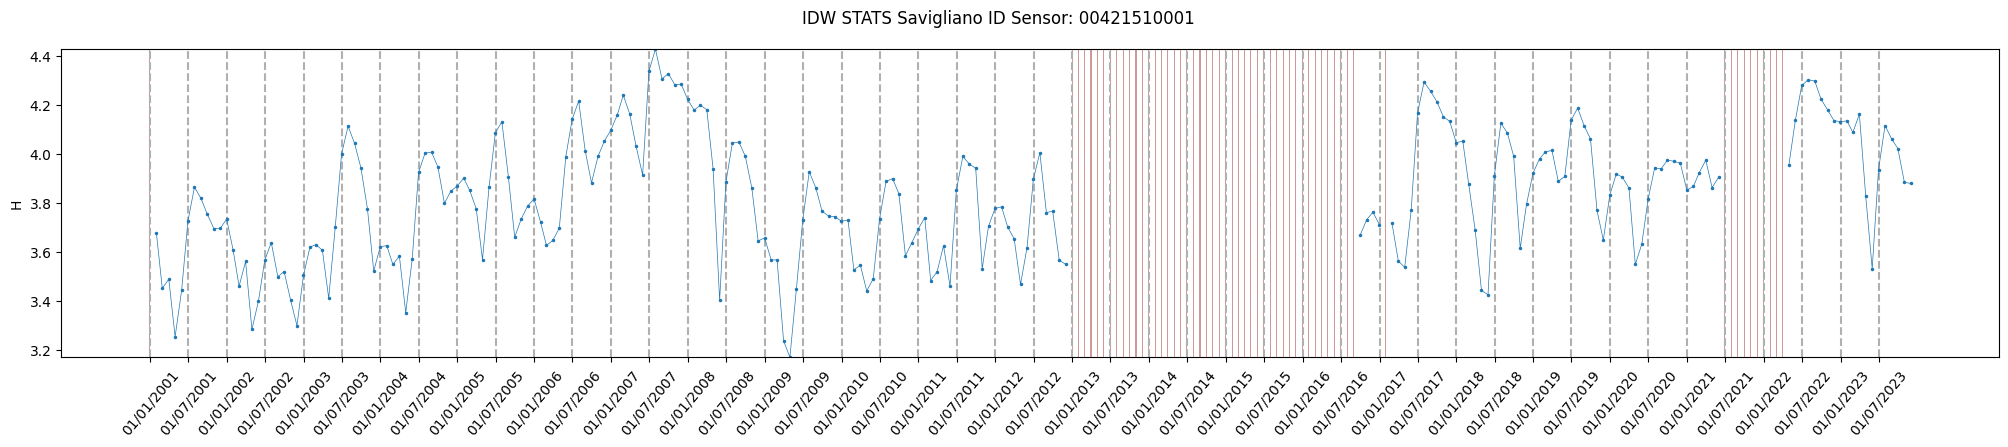

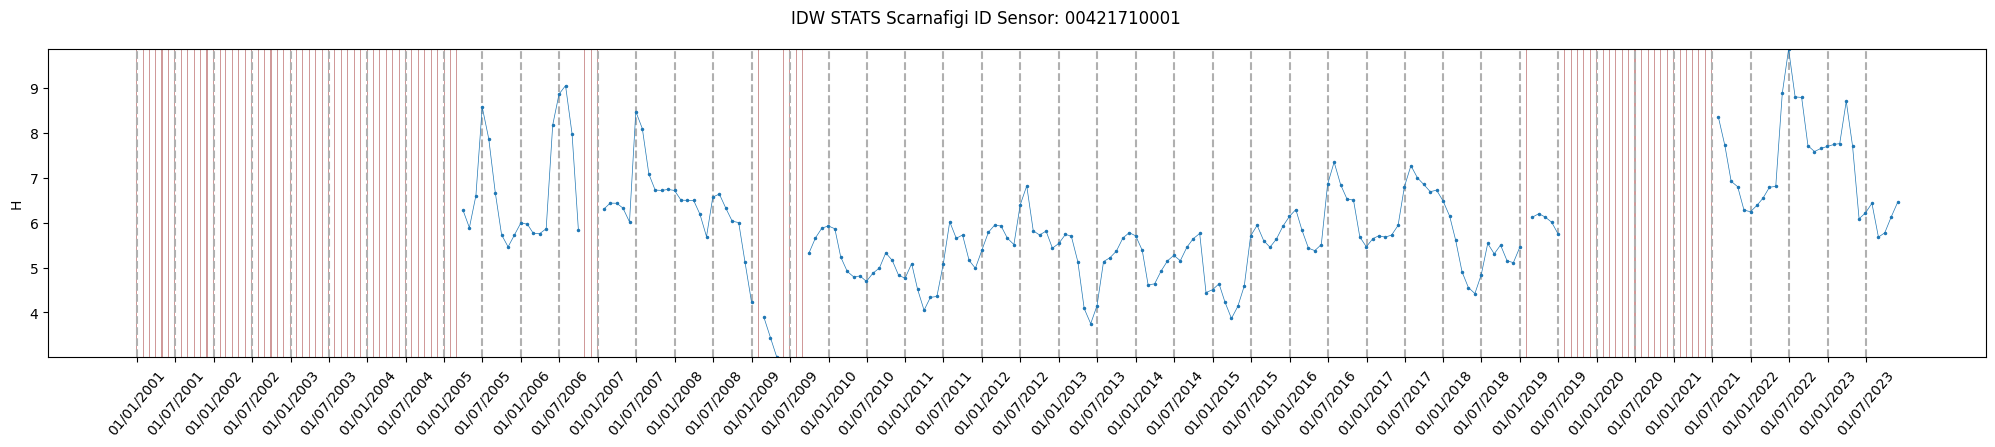

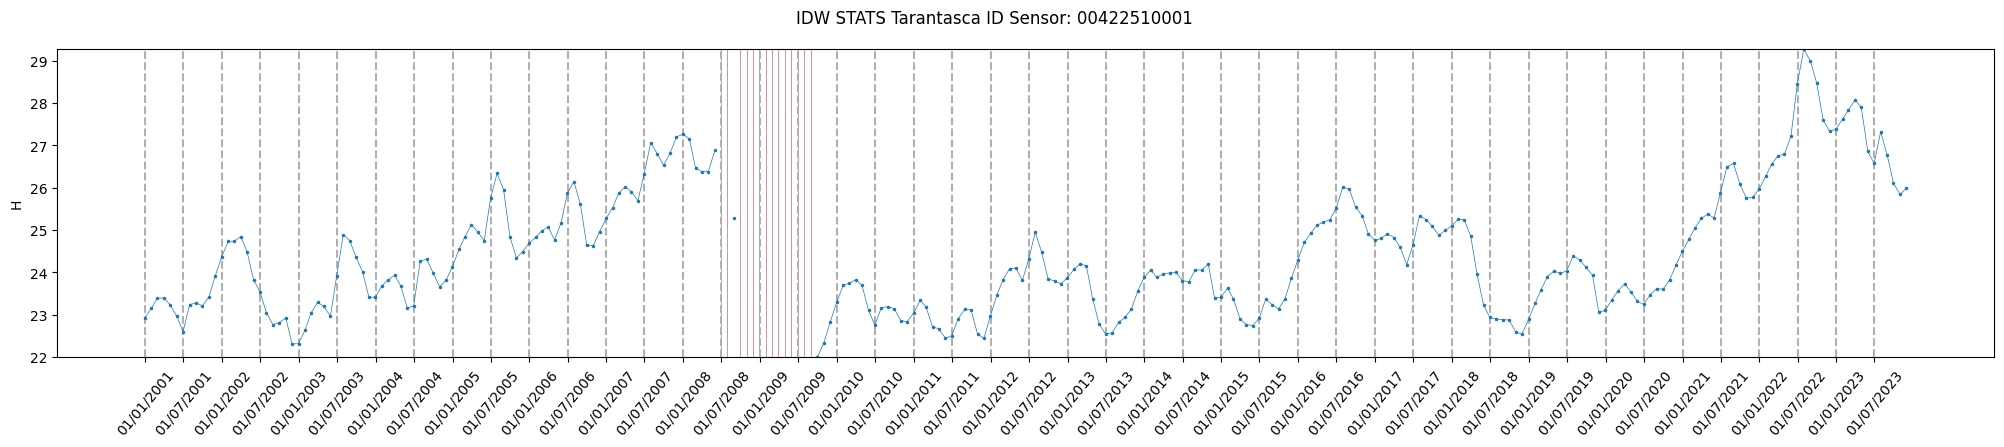

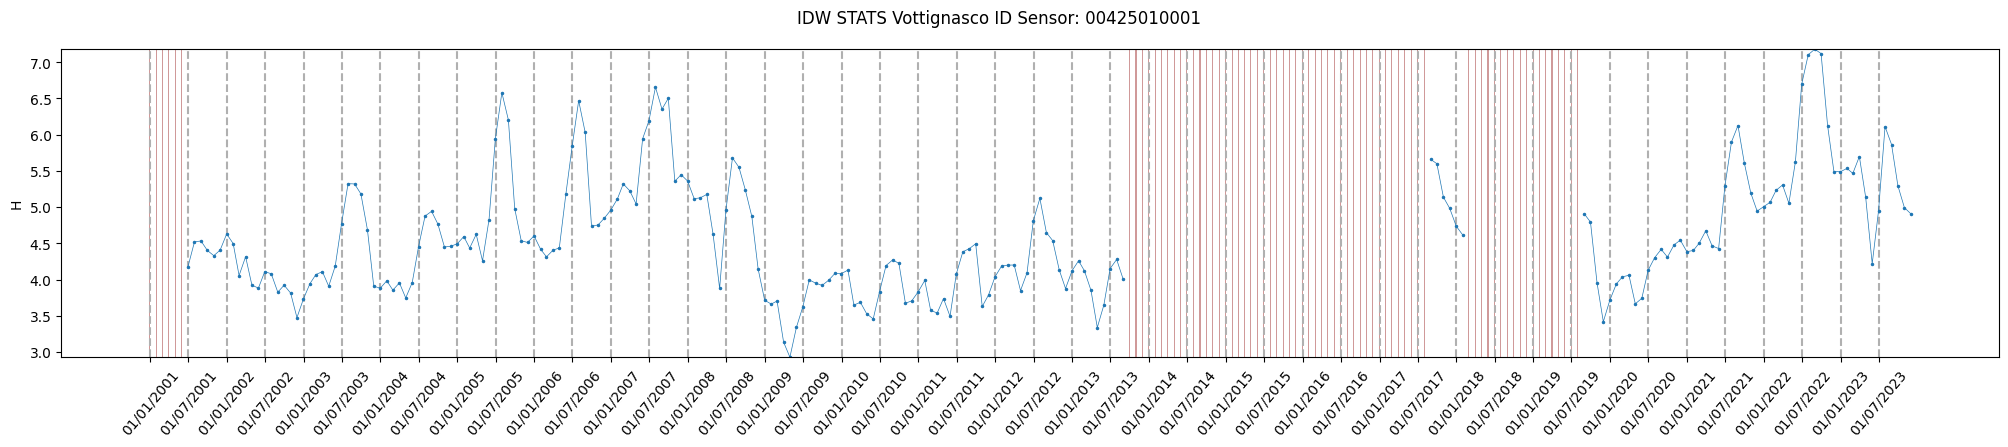

In [202]:
weekly_sensor_list = ds.sensor_id_list
for sensor_idx in range(len(weekly_sensor_list)):
        
    sensor_series = ds.wtd_df["wtd"].loc[pd.IndexSlice[:, weekly_sensor_list[sensor_idx]]]
    
    #sensor_series = (sensor_series * ds.norm_factors["target_std"]) + ds.norm_factors["target_mean"]
    
    sensor_series_dates = sensor_series.index.get_level_values(0)
    
    municipality = ds.wtd_names.loc[ds.wtd_names["sensor_id"] == weekly_sensor_list[sensor_idx],
                                    "munic"].values[0]
    
    fig, ax = plt.subplots(figsize = (25,4))
    
    fig.suptitle(f"IDW STATS {municipality} ID Sensor: {weekly_sensor_list[sensor_idx]}")
    
    ax.plot(sensor_series_dates,
            sensor_series.values, 
            marker = "o",
            lw = 0.5,
            markersize = 1.5)
    
    ax.set_ylabel("H")
    
    date_xticks = pd.date_range(np.datetime64("2001-01-01"), np.datetime64("2023-12-31"), freq = "6MS",  normalize = True, inclusive = "both")
    
    ax.set_ylim([sensor_series.min(),
                 sensor_series.max()])
    
    ax.bar(sensor_series_dates[sensor_series.isnull()],
                      bottom = ax.get_ylim()[0],
                      height = ax.get_ylim()[1],
                      width= 5,
                      align='center',
                      color = 'darkred',
                      alpha = 0.4,
                      label = "Water Table\nMissing Values", zorder = 0)
    
    ax.set_xticks(date_xticks, date_xticks.strftime('%d/%m/%Y'))
    ax.tick_params(axis = "x", rotation=50 )
    ax.grid(axis="x", ls = "--", which = "both", lw = "1.5")

# Model 

In [10]:
from models import models_SparseData
importlib.reload(models_SparseData)
from models import load_model
importlib.reload(load_model)

<module 'models.load_model' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model.py'>

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [12]:
model, _ = load_model.load_model(dict_files)

Model: SparseData_Transformer_MoE
Initialization: He


In [13]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    
model = model.apply(weight_init)

In [14]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  931842


In [17]:
model.train()
prova_out = model(ds[0][0].unsqueeze(0),
                       ds[0][1].unsqueeze(0),
                       [ds[0][2][0].unsqueeze(0),
                        ds[0][2][1].unsqueeze(0)],
                       ds[0][-2].unsqueeze(0),
                       teacher_forcing = True)

In [18]:
prova_out.shape

torch.Size([12, 28])

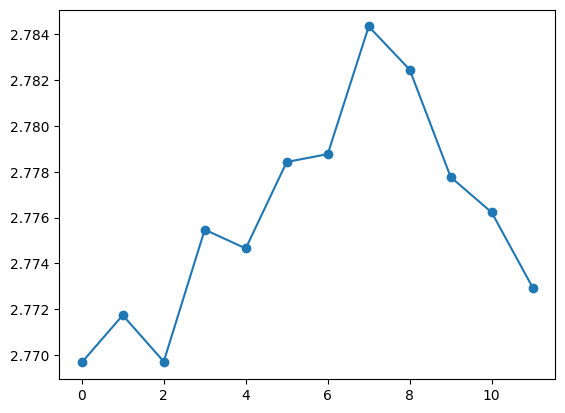

In [19]:
sensor = 5
plt.plot(prova_out[:,sensor].detach().cpu(), marker = "o")

In [20]:
model.eval()
prova_out_eval = model(ds[0][0][0,:,:].unsqueeze(0),
                       ds[0][1].unsqueeze(0),
                       [ds[0][2][0].unsqueeze(0),
                        ds[0][2][1].unsqueeze(0)],
                       ds[0][-2][0,:].unsqueeze(0),
                       teacher_forcing = False)

100%|██████████| 12/12 [00:03<00:00,  3.05it/s]


In [21]:
prova_out_eval.shape

torch.Size([12, 28])

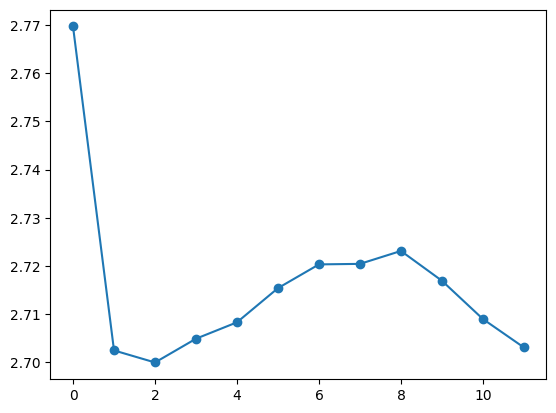

In [22]:
sensor = 5
plt.plot(prova_out_eval[:,sensor].detach().cpu(), marker = "o")

In [18]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

## Grid prediction

In [31]:
date = "2020-01-01"
twindow = 3
lat_points = 42
lon_points = 62
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 3/3 [00:13<00:00,  4.36s/it]


In [32]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)

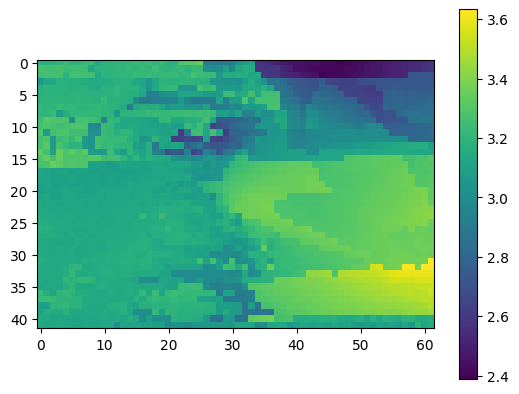

In [33]:
plt.imshow(Y_hat_test_grid[2,:,:])
plt.colorbar()

In [235]:
ds.target_means_xr.values[2,0]

AttributeError: 'Dataset_Sparse' object has no attribute 'target_means_xr'

In [55]:
(Y_hat_test_grid[:,0,0] * ds.target_stds_xr.values[0,0]) + ds.target_means_xr.values[0,0]

tensor([348.2361, 349.0766, 349.1225])

In [236]:
Y_hat_test_grid_denorm = (Y_hat_test_grid * ds.target_stds_xr.values) + ds.target_means_xr.values

AttributeError: 'Dataset_Sparse' object has no attribute 'target_stds_xr'

In [238]:
Y_hat_test_grid_denorm = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

/scratch_local/ipykernel_3316216/1525610506.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.log(Y_hat_test_grid_denorm[2,:,:]))


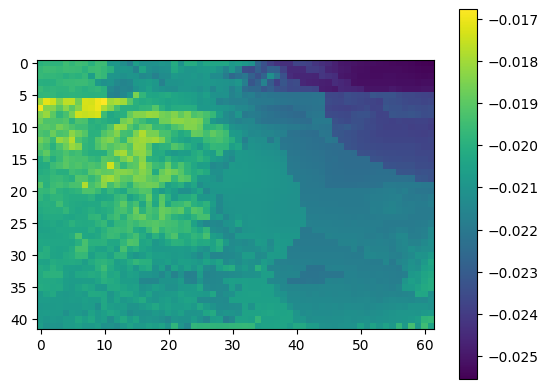

In [239]:
plt.imshow(np.log(Y_hat_test_grid_denorm[2,:,:]))
plt.colorbar()

In [49]:
Y_hat_xr = xarray.DataArray(data = Y_hat_test_grid,
                                coords = dict(
                                            lat=("lat", ((coords[:,0,0] * ds.norm_factors["lat_std"]) + ds.norm_factors["lat_mean"])),
                                            lon=("lon", ((coords[0,:,1] * ds.norm_factors["lon_std"]) + ds.norm_factors["lon_mean"])),
                                            time=pd.date_range(np.datetime64(date),
                                                            np.datetime64(date) + np.timedelta64(twindow-1, dict_files["frequency"]),
                                                            freq = dict_files["frequency"])),
                                dims = ["time","lat", "lon"]
                                )

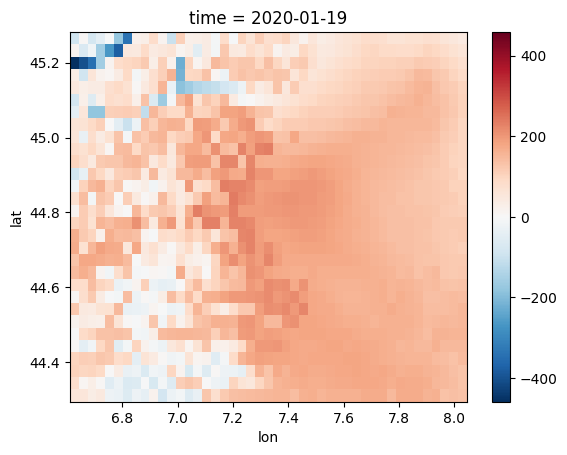

In [52]:
Y_hat_xr[2].plot()

## Load trained model

In [16]:
model_name_path = "model_SparseData_Transformer_MoE_20250722_091730" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

SparseData_Transformer_MoE(
  (activation_fn): LeakyReLU(negative_slope=0.01)
  (topo_embedder): Topographical_Embdedding(
    (activation): LeakyReLU(negative_slope=0.01)
    (topo_embeddings): Sequential(
      (0): Linear(in_features=3, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (SparseAutoreg_Module): Spatial_Attention_Block_MoE(
    (activation): LeakyReLU(negative_slope=0.01)
    (topo_embeddings): Topographical_Embdedding(
      (activation): LeakyReLU(negative_slope=0.01)
      (topo_embeddings): Sequential(
        (0): Linear(in_features=3, out_features=16, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
    )
    (value_embeddings): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (cb_multihead_att_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (moe_block): SparseMoEB

In [19]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


In [20]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

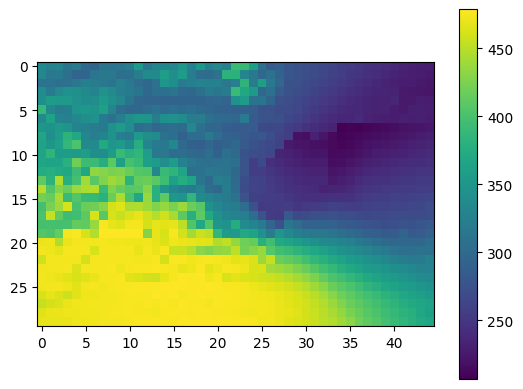

In [26]:
plt.imshow(Y_hat_test_grid[4,:,:])
plt.colorbar()

# Loss

In [147]:
from loss import losses_SparseData
importlib.reload(losses_SparseData)

<module 'loss.losses_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/loss/losses_SparseData.py'>

In [137]:
batch_s = 5
x_batch = torch.stack([ds[i][0] for i in range(batch_s)], dim = 0)
z_batch = torch.stack([ds[i][1] for i in range(batch_s)], dim = 0)
w0_batch = torch.stack([ds[0][2][0] for i in range(batch_s)], dim = 0)
w1_batch = torch.stack([ds[0][2][1] for i in range(batch_s)], dim = 0)
w_batch = [w0_batch, w1_batch]
true_batch = torch.stack([ds[i][-3] for i in range(batch_s)], dim = 0)
xmask_batch = torch.stack([ds[i][-2] for i in range(batch_s)], dim = 0)
ymask_batch = torch.stack([ds[i][-1] for i in range(batch_s)], dim = 0)

In [138]:
model.train()
out_batch = model(x_batch,
                  z_batch,
                  w_batch,
                  xmask_batch,
                       teacher_forcing = True)

In [139]:
norm_factor = [torch.tensor(ds.norm_factors["target_means"]).to(out_batch.device).to(torch.float32),
            torch.tensor(ds.norm_factors["target_stds"]).to(out_batch.device).to(torch.float32)
            ]

In [87]:
out_batch.shape

torch.Size([5, 26, 28])

In [92]:
true_batch.shape

torch.Size([5, 26, 28])

In [155]:
losses_SparseData.loss_masked_h2(out_batch, true_batch, ymask_batch,
            norm_factor)

tensor([[[ 90.5781,  92.5830, 174.8781,  ...,  29.5957,  22.5359,  22.7983],
         [-64.9565, 140.8301, 129.6301,  ..., 140.9766, -96.3849, -89.1852],
         [365.5546, 294.0675, 331.7056,  ..., 175.5725, -87.6100, -76.2506],
         ...,
         [132.6866, 142.8001, 102.6010,  ..., 179.1476, 217.8306, 159.3986],
         [144.0751, 129.7386, 119.3159,  ..., 178.4463, 214.8107, 164.2427],
         [ 94.8056, 176.8314, 163.9642,  ..., 208.4325, 158.4632, 236.5394]],

        [[606.7235, 489.5417, 328.0421,  ..., 177.7885, 223.4379, 154.7892],
         [406.4716, 359.2103, 241.4683,  ..., 133.3777,  28.8863,  31.6063],
         [681.2541, 538.9100, 276.3175,  ...,   3.5021, 166.3419, 149.5751],
         ...,
         [233.0011, 172.5778, 160.3578,  ..., 268.0643, 193.9412, 220.2015],
         [261.3091, 267.8188, 282.5597,  ..., 237.8039, 175.3546, 191.8213],
         [260.9424, 256.3831, 264.4753,  ..., 270.7410, 223.3766, 209.6097]],

        [[405.7957, 393.7622, 336.9928,  ...

tensor(453407.5312, grad_fn=<DivBackward0>)

In [150]:
h2_denorm = losses_SparseData.point_h2((out_batch* norm_factor[1]) + norm_factor[0],
         (true_batch* norm_factor[1]) + norm_factor[0],
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [151]:
h2_norm = losses_SparseData.point_h2(out_batch,
         true_batch,
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [156]:
Y_tstep_avail_mask = (torch.sum(ymask_batch, dim = 1) > 1)
Y_tstep_avail_mask.shape

torch.Size([5, 28])

In [157]:
torch.sum(h2_denorm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(453407.5312, grad_fn=<DivBackward0>)

In [158]:
torch.sum(h2_norm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(1748253.1250, grad_fn=<DivBackward0>)